# Import & Data loading

In [77]:
import random
import plotly
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
from matplotlib import pyplot
import matplotlib.pyplot as plt
pio.renderers.default = "iframe"
import plotly.graph_objects as go
from tensorflow.keras.layers import LSTM,Dense
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
#pip install numpy scipy patsy pandas


In [3]:
#pip install statsmodels


In [4]:
#import  scipy.signal.signaltools

#def _centered(arr, newsize):
    # Return the center newsize portion of the array.
 #   newsize = np.asarray(newsize)
  #  currsize = np.array(arr.shape)
   # startind = (currsize - newsize) // 2
    #endind = startind + newsize
    #myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
   # return arr[tuple(myslice)]

#scipy.signal.signaltools._centered = _centered

In [5]:
df = pd.read_csv('/Users/idanvazana/Library/Mobile Documents/com~apple~CloudDocs/M.sc - Data Science/סמסטר ב/סדרות עתיות/מטלה/city_temperature.csv')

In [6]:
df

,Region,Country,State,City,Month,Day,Year,AvgTemperature F,AvgTemperature C
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2,17.888889
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4,9.666667
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8,9.333333
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4,8.000000
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9,8.833333
...,...,...,...,...,...,...,...,...,...
1048570,Middle East,Oman,NaN,Muscat,2,7,1999,-99.0,-72.777778
1048571,Middle East,Oman,NaN,Muscat,2,8,1999,-99.0,-72.777778
1048572,Middle East,Oman,NaN,Muscat,2,9,1999,-99.0,-72.777778
1048573,Middle East,Oman,NaN,Muscat,2,10,1999,-99.0,-72.777778


In [7]:
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature F,AvgTemperature C
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2,17.888889
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4,9.666667
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8,9.333333
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4,8.000000
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9,8.833333


# Exploratory data analysis

In [8]:
df.shape

(1048575, 9)

In [9]:
print(df.value_counts())

Series([], dtype: int64)


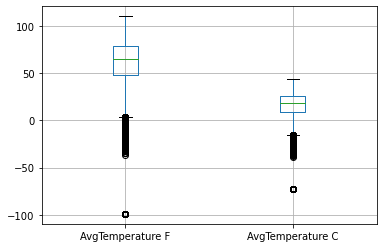

In [10]:
boxplot = df.boxplot(column=['AvgTemperature F', 'AvgTemperature C'])

Changing the variable names

In [11]:
df.rename(columns = {'AvgTemperature F' : 'AvgTemperatureF', 'AvgTemperature C' : 'AvgTemperatureC'}, inplace = True)

Remove outliers

In [12]:
df= df[df.AvgTemperatureF >= -60]


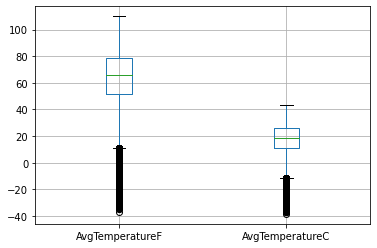

In [13]:
boxplot = df.boxplot(column=['AvgTemperatureF', 'AvgTemperatureC'])

In [14]:
df.isnull().values.any()


True

In [15]:
df.isnull().sum()

Region                  0
Country                 0
State              992090
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperatureF         0
AvgTemperatureC         0
dtype: int64

In [16]:
df.drop(['State','AvgTemperatureC'], axis=1, inplace=True)

/Users/idanvazana/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
df.shape

(992090, 7)

Convert to one date column

In [18]:
df['date'] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=df.Day))


<ipython-input-18-ab340640c062>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Average Temerature across the 5 regions

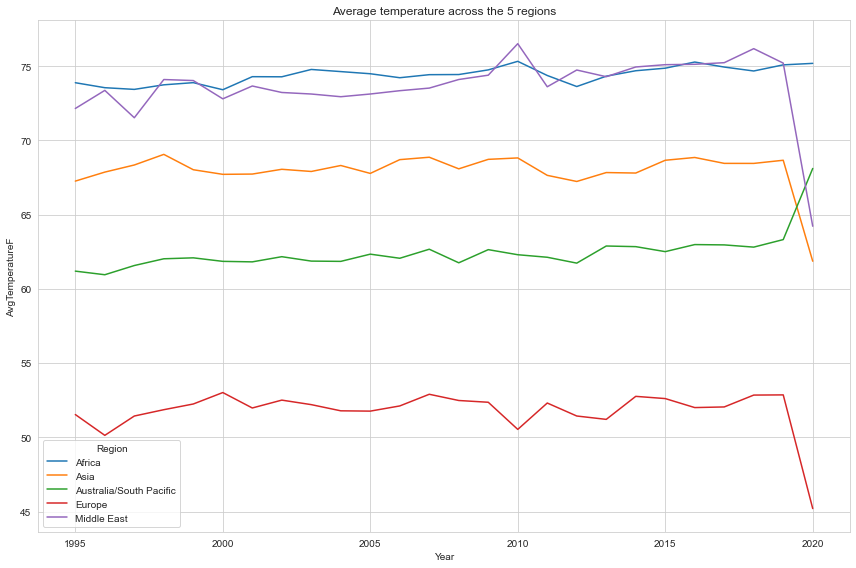

In [19]:
data = df[['Region','AvgTemperatureF','Year']].groupby(['Region','Year']).mean()
data = data.reset_index(level=0)

sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=data,hue='Region',x='Year',y='AvgTemperatureF')
_=plt.title('Average temperature across the 5 regions')
plt.tight_layout()

Average Temperature of the World from 1995 to 2020 with linear fit

In [20]:
data = df[['Year','AvgTemperatureF']].groupby('Year').mean()
linfit = np.polyfit(data.index,data['AvgTemperatureF'],deg=1)
linfit = linfit[0]*data.index + linfit[1]

fig = px.line(data,title='Average Temperature of the World from 1995 to 2020')
fig.add_trace(go.Scatter(x=data.index,y=linfit,name='Linear Fit'))

Changing the month label from integer to name & Map charts

In [21]:
data = df[['Region','Month','AvgTemperatureF']]
data = data.groupby(['Region','Month']).mean()

months = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:"Dec"}
data = data.reset_index(level=1)

data['Month'] = data.loc[:,'Month'].map(months)
data.head(5)

,Month,AvgTemperatureF
Region,,
Africa,Jan,72.565024
Africa,Feb,73.756690
Africa,Mar,74.747041
Africa,Apr,74.942885
Africa,May,75.001612


In [22]:
data1=df.sort_values(by=['AvgTemperatureF'],ascending=False).head(1)
data2=df.sort_values(by=['AvgTemperatureF'],ascending=True).head(1)
data = pd.concat([data1,data2],)
data.index = ['Highest','Lowest']
data

,Region,Country,City,Month,Day,Year,AvgTemperatureF,date
Highest,Middle East,Kuwait,Kuwait,8,1,2012,110.0,2012-08-01
Lowest,Asia,Mongolia,Ulan-bator,1,8,2001,-37.2,2001-01-08


In [23]:
px.scatter_geo(lat=[29.3117,64.8378],lon=[29.3117,147.7164],text=['Kuwait','Mongolia'],size=[0.5,0.5],color=[110,-50],color_continuous_scale='bluered')

In [24]:
data = df[['Country','AvgTemperatureF']].groupby('Country').mean().sort_values('AvgTemperatureF')
print('The top five coldest countries in the world are: ',data.index[:5].to_list())
print('The top five hottest countries in the world are: ',data.index[-5:].to_list())

The top five coldest countries in the world are:  ['Mongolia', 'Iceland', 'Norway', 'Finland', 'Latvia']
The top five hottest countries in the world are:  ['Philippines', 'Indonesia', 'Thailand', 'Nigeria', 'Oman']


In [25]:
data = df[['Country','Year','AvgTemperatureF']].groupby(['Country','Year']).mean().reset_index()
px.choropleth(data_frame=data,locations="Country",locationmode='country names',animation_frame="Year",color='AvgTemperatureF',color_continuous_scale = 'Turbo',title="Choropleth plot of countrywise average temperature over the years 1995 to 2019")

In [26]:
df

,Region,Country,City,Month,Day,Year,AvgTemperatureF,date
0,Africa,Algeria,Algiers,1,1,1995,64.2,1995-01-01
1,Africa,Algeria,Algiers,1,2,1995,49.4,1995-01-02
2,Africa,Algeria,Algiers,1,3,1995,48.8,1995-01-03
3,Africa,Algeria,Algiers,1,4,1995,46.4,1995-01-04
4,Africa,Algeria,Algiers,1,5,1995,47.9,1995-01-05
...,...,...,...,...,...,...,...,...
1047071,Middle East,Lebanon,Beirut,5,13,2020,67.8,2020-05-13
1047180,Middle East,Oman,Muscat,4,19,1995,82.8,1995-04-19
1047338,Middle East,Oman,Muscat,9,24,1995,94.5,1995-09-24
1047339,Middle East,Oman,Muscat,9,25,1995,92.6,1995-09-25


In [27]:
df_new=df[df.Country =='Israel']
df_new
df_new2=df_new
df_=df_new
df_new

,Region,Country,City,Month,Day,Year,AvgTemperatureF,date
1014633,Middle East,Israel,Tel Aviv,1,1,1995,57.3,1995-01-01
1014634,Middle East,Israel,Tel Aviv,1,2,1995,56.1,1995-01-02
1014635,Middle East,Israel,Tel Aviv,1,3,1995,55.9,1995-01-03
1014636,Middle East,Israel,Tel Aviv,1,4,1995,56.9,1995-01-04
1014637,Middle East,Israel,Tel Aviv,1,5,1995,56.6,1995-01-05
...,...,...,...,...,...,...,...,...
1019269,Middle East,Israel,Tel Aviv,9,11,2007,79.5,2007-09-11
1019270,Middle East,Israel,Tel Aviv,9,12,2007,79.7,2007-09-12
1019271,Middle East,Israel,Tel Aviv,9,13,2007,79.7,2007-09-13
1019272,Middle East,Israel,Tel Aviv,9,14,2007,79.6,2007-09-14


In [28]:
import plotly.express as px

fig = px.bar(df_new, x = "date", y = "AvgTemperatureF", color = "Month", template="simple_white")
fig.show()

In [29]:
df1=df
df1 = df1[df1.Country == 'Israel']
df1.drop(['Region','City', 'Month', 'Day', 'Year','Country'], axis=1, inplace=True)

/Users/idanvazana/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
df1.sort_values(by=['date'])

,AvgTemperatureF,date
1014633,57.3,1995-01-01
1014634,56.1,1995-01-02
1014635,55.9,1995-01-03
1014636,56.9,1995-01-04
1014637,56.6,1995-01-05
...,...,...
1019269,79.5,2007-09-11
1019270,79.7,2007-09-12
1019271,79.7,2007-09-13
1019272,79.6,2007-09-14


In [31]:
new_cols = ["date","AvgTemperatureF"]
df2=df1[new_cols]
df2=df2[(df2['date'] < "2007-01-01")]
df2 = df2.set_index('date')

df2.head().style.set_properties(subset=['AvgTemperatureF'], **{'background-color': 'dodgerblue'})

,AvgTemperatureF
date,
1995-01-01 00:00:00,57.300000
1995-01-02 00:00:00,56.100000
1995-01-03 00:00:00,55.900000
1995-01-04 00:00:00,56.900000
1995-01-05 00:00:00,56.600000


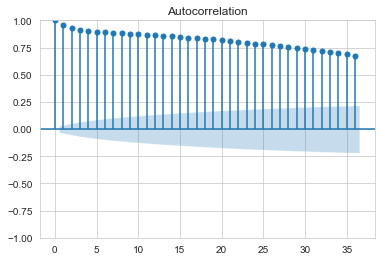

In [32]:
plot_acf(df2)
pyplot.show()

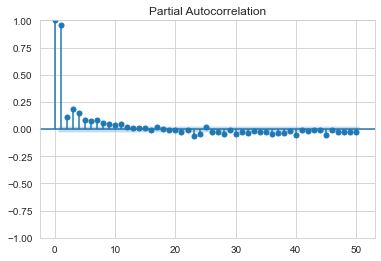

In [33]:
plot_pacf(df2, lags=50)
pyplot.show()

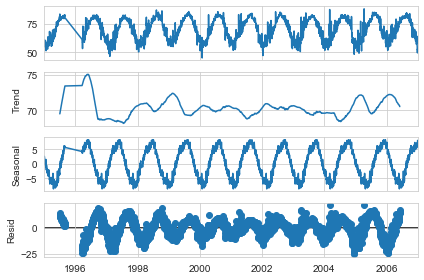

In [34]:
seasonal_decompose(df2,period=365).plot()
plt.show()

Time series Tel-Aviv daily temprature between 1995-2007

In [35]:
px.line(data_frame=df2,color_discrete_sequence=['cornflowerblue'],title="Daily Average Temperature - Tel-Aviv (1995-2007)")

Decompose function for the time series to seperate trand & seasonal

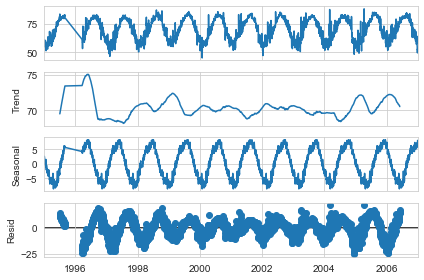

In [36]:
decompose = seasonal_decompose(df2,period=365)
decompose.plot();

Non-Stationary Time Series

Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index.

Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture.
https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf


In [37]:
roll_mean = df2.rolling(window=31).std()
roll_mean2 = df2.rolling(window=365).std()
fig = go.Figure()
fig.add_trace(go.Scatter(x=roll_mean.index,y=roll_mean['AvgTemperatureF'],marker=dict(color='red'),name='31DaysRolling'))
fig.add_trace(go.Scatter(x=roll_mean2.index,y=roll_mean2['AvgTemperatureF'],marker=dict(color='green'),name='365DaysRolling'))
fig.update_layout(dict(title='Standard deviation on a timeline'))

Dickey Fuller test to verify the stationarity | 
H0: The time series data is non stationary | p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


https://machinelearningmastery.com/time-series-data-stationary-python/

In [38]:
adf = adfuller(x=df2['AvgTemperatureF'])
print('P-value:',adf[1])
print('ADF:',adf[0])
print('Critical_values:',adf[4])

P-value: 0.00012166589141908962
ADF: -4.614082360008789
Critical_values: {'1%': -3.4320222706340395, '5%': -2.8622789176205625, '10%': -2.5671633344910636}


The pvalue is very small, close to 0. The data is stationary



# Models & Evaluation

LSTM MODEL

In [80]:
df2

,AvgTemperatureF
date,
1995-01-01,0.281106
1995-01-02,0.253456
1995-01-03,0.248848
1995-01-04,0.271889
1995-01-05,0.264977
...,...
2006-12-24,0.269585
2006-12-26,0.246544
2006-12-29,0.103687


In [81]:
test = df2[df2.index>'2006']
train = df2[df2.index<'2006']

In [82]:
print(train.size)
test.size

3616


329

In [83]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [84]:
time_steps = 20
features = 1

train_gen = TimeseriesGenerator(train,train,time_steps,batch_size=4)
test_gen = TimeseriesGenerator(test,test,time_steps,batch_size=4)

In [89]:
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(LSTM(365,activation='relu',input_shape=(time_steps,features),return_sequences=True))
model.add(LSTM(32,activation='relu'))
model.add(Dense(1,activation='relu'))

# Set the optimizer to SGD
learning_rate = 0.001  # Specify your desired learning rate
optimizer = SGD(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mse')

#model.compile(optimizer='adam',loss='mse')

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 365)           535820    
                                                                 
 lstm_13 (LSTM)              (None, 32)                50944     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 586,797
Trainable params: 586,797
Non-trainable params: 0
_________________________________________________________________


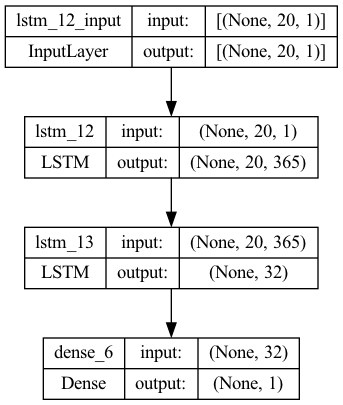

In [90]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [91]:
early_stop = EarlyStopping(patience=5)

In [92]:
pip install git+https://github.com/paulgavrikov/visualkeras --upgrade


  Cloning https://github.com/paulgavrikov/visualkeras to /private/var/folders/qq/247gkld9091fw63mm4d755yr0000gn/T/pip-req-build-iq6mw_r7
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /private/var/folders/qq/247gkld9091fw63mm4d755yr0000gn/T/pip-req-build-iq6mw_r7
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [93]:
model.fit(x=train_gen,epochs=4,callbacks=[early_stop],validation_data=test_gen)

#Save the model
model.save('LSTMAvgTemp.h5')

Epoch 1/4
899/899 [==============================] - 42s 44ms/step - loss: 0.0584 - val_loss: 0.0197
Epoch 2/4
899/899 [==============================] - 43s 47ms/step - loss: 0.0220 - val_loss: 0.0167
Epoch 3/4
899/899 [==============================] - 43s 48ms/step - loss: 0.0182 - val_loss: 0.0142
Epoch 4/4
899/899 [==============================] - 44s 49ms/step - loss: 0.0149 - val_loss: 0.0112


In [94]:
predict = model.predict(test_gen)
test_targets = test_gen.targets[test_gen.start_index:test_gen.end_index+1]

78/78 [==============================] - 1s 13ms/step


In [95]:
predict = scaler.inverse_transform(predict).ravel()
test_targets = scaler.inverse_transform(test_targets).ravel()

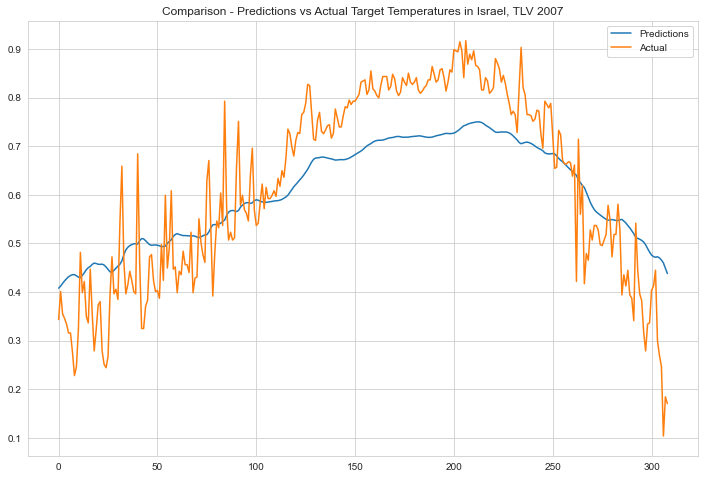

In [96]:
_,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(x=range(len(predict)),y=predict,ax=ax,label='Predictions')
sns.lineplot(x=range(len(test_targets)),y=test_targets,ax=ax,label='Actual')
plt.legend()
_=plt.title('Comparison - Predictions vs Actual Target Temperatures in Israel, TLV 2007')

In [97]:
print('The RMSE Score is:',format(np.sqrt(mean_squared_error(predict,test_targets)),'.2f'))
# Calculate RMSE score:
print('The RMSE Score is:',format(np.sqrt(mean_squared_error(predict, test_targets)),'.2f'))
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets, predict)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared (R²) or Coefficient of Determination
r_squared = r2_score(test_targets, predict)
print("R-squared (R²) or Coefficient of Determination:", r_squared)

The RMSE Score is: 0.11
The RMSE Score is: 0.11
Mean Absolute Error (MAE): 0.09023200443972784
R-squared (R²) or Coefficient of Determination: 0.6974916020369626


In [98]:
data = df2.iloc[-time_steps:].to_numpy() #2D Array
data = scaler.transform(data)

#expand to include batch dimension
data = np.expand_dims(data,0)

#record the last date of observartion from the data
date = df2.index[-1]

date_store = df2.iloc[-time_steps:].index.to_list()

#forecasting
forecasts=10
for i in range(forecasts):
    predicted = model.predict(data[:,-20:,:])
    date = date+datetime.timedelta(days=1)
    data = np.append(data,[predicted],axis=1)
    date_store.append(date)
data = scaler.inverse_transform(data.reshape(1,-1))
forecast_df = pd.DataFrame(index=date_store[time_steps-1:],data={'AvgTemperatureF':data.ravel()[time_steps-1:]})

/Users/idanvazana/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:420: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 39ms/step


In [99]:
forecast_df

,AvgTemperatureF
2006-12-31,0.170507
2007-01-01,0.427179
2007-01-02,0.424521
2007-01-03,0.426584
2007-01-04,0.431556
2007-01-05,0.437417
2007-01-06,0.444471
2007-01-07,0.452012
2007-01-08,0.459609
2007-01-09,0.467236


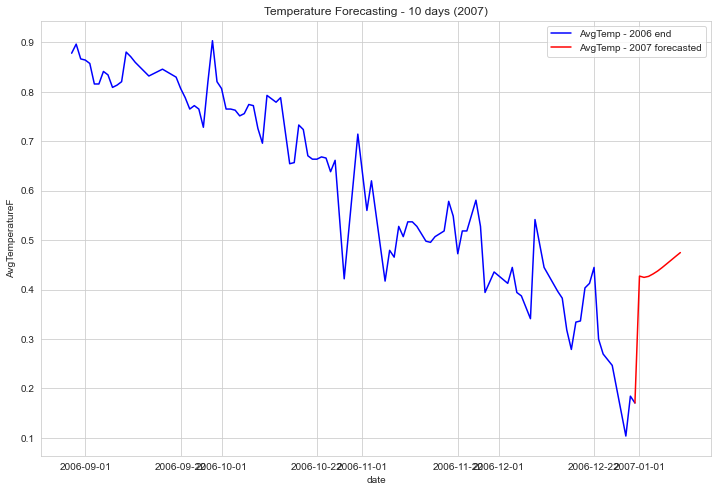

In [100]:
_,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data=df2.iloc[-100:,:],y='AvgTemperatureF',x=df2.iloc[-100:,:].index,color='blue',ax=ax,label='AvgTemp - 2006 end')
sns.lineplot(data=forecast_df,y='AvgTemperatureF',x=forecast_df.index,color='red',ax=ax,label= 'AvgTemp - 2007 forecasted')
_=plt.title(f'Temperature Forecasting - {forecasts} days (2007)')

Bi-LSTM Model

In [101]:
# Assuming  dataframe 'df2' has two columns: 'date' and 'average temperature'

# Preprocessing: Scaling the data
scaler = MinMaxScaler()
df2['AvgTemperatureF'] = scaler.fit_transform(df2['AvgTemperatureF'].values.reshape(-1, 1))

# Train-test split
train_size = int(len(df2) * 0.9)  # 90% for training, 10% for testing
train_data = df2[:train_size]
test_data = df2[train_size:]

# Prepare data for BiLSTM
time_steps = 20  # Number of previous time steps to consider
features = 1  # Number of features (temperature column)

train_gen = TimeseriesGenerator(train_data['AvgTemperatureF'].values, train_data['AvgTemperatureF'].values,
                               length=time_steps, batch_size=4)
test_gen = TimeseriesGenerator(test_data['AvgTemperatureF'].values, test_data['AvgTemperatureF'].values,
                              length=time_steps, batch_size=4)



In [102]:
# BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(365, activation='relu', return_sequences=True), input_shape=(time_steps, features)))
model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 20, 730)          1071640   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               195328    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,267,033
Trainable params: 1,267,033
Non-trainable params: 0
_________________________________________________________________


In [103]:
# Model training
early_stop = EarlyStopping(patience=5)
model.fit(x=train_gen, epochs=4, callbacks=[early_stop], validation_data=test_gen)


Epoch 1/4
883/883 [==============================] - 93s 99ms/step - loss: 0.0082 - val_loss: 0.0044
Epoch 2/4
883/883 [==============================] - 88s 100ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 3/4
883/883 [==============================] - 88s 100ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 4/4
883/883 [==============================] - 111s 126ms/step - loss: 0.0037 - val_loss: 0.0038


375/375 [==============================] - 6s 14ms/step


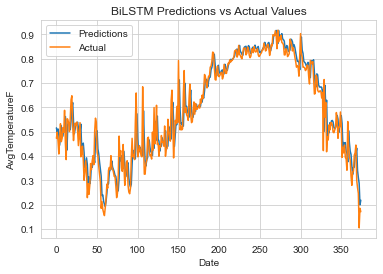

In [104]:
# Prediction
test_gen = TimeseriesGenerator(test_data['AvgTemperatureF'].values, test_data['AvgTemperatureF'].values,
                              length=time_steps, batch_size=1)  # Use batch_size=1 for individual predictions
#test_targets = test_gen.targets[test_gen.start_index:test_gen.end_index+1]

#predictions = model.predict(test_gen)

predict = model.predict(test_gen)
test_targets = test_gen.targets[test_gen.start_index:test_gen.end_index+1].reshape(-1, 1)

predict = scaler.inverse_transform(predict).ravel()
test_targets = scaler.inverse_transform(test_targets).ravel()

# Rescale predictions and actual values
#predictions = scaler.inverse_transform(predictions).ravel()
#actual_values = scaler.inverse_transform(test_data['AvgTemperatureF'].values.reshape(-1, 1)).ravel()

# Plotting predictions vs actual values
plt.plot(predict, label='Predictions')
plt.plot(test_targets, label='Actual')
plt.xlabel('Date')
plt.ylabel('AvgTemperatureF')
plt.title('BiLSTM Predictions vs Actual Values')
plt.legend()
plt.show()

In [105]:
# Calculate RMSE score:
print('The RMSE Score is:',format(np.sqrt(mean_squared_error(predict, test_targets)),'.2f'))
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets, predict)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared (R²) or Coefficient of Determination
r_squared = r2_score(test_targets, predict)
print("R-squared (R²) or Coefficient of Determination:", r_squared)

The RMSE Score is: 0.06
Mean Absolute Error (MAE): 0.042264063309597685
R-squared (R²) or Coefficient of Determination: 0.9053920831085718
